# Data Cleaning
****

We used SQL to create a single csv file with the necessary data for us. Next we will do some higher level cleaning. Including using KNN to guess at missing values. Many of these ideas were borrowed from https://www.kaggle.com/nikunjm88/carefully-dealing-with-missing-values


In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

First We will import the modules we need as well as the SQL shortened data sets

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import nltk
import datetime
import math
from sklearn import neighbors
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_2016 = pd.read_csv('2016.csv')
raw_2017 = pd.read_csv('2017.csv')

In [3]:
combined_df = pd.concat([raw_2016,raw_2017]).copy()
#combined_df.set_index('parcelid', inplace=True)
print(len(combined_df['parcelid'].unique()),len(combined_df['parcelid']))
print(len(raw_2016['parcelid']),len(raw_2017['parcelid']),len(combined_df['parcelid']))
combined_df.head()

165210 167888
90275 77613 167888


,Unnamed: 0,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,...,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111002e+13,0.0953,2016-01-27
1,1,17088994,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,143809.0,239679.0,2015.0,95870.0,2581.30,NaN,NaN,6.111002e+13,0.0198,2016-03-30
2,2,17100444,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,33619.0,47853.0,2015.0,14234.0,591.64,NaN,NaN,6.111001e+13,0.0060,2016-05-27
3,3,17102429,NaN,NaN,NaN,1.5,2.0,NaN,NaN,1.5,...,45609.0,62914.0,2015.0,17305.0,682.78,NaN,NaN,6.111001e+13,-0.0566,2016-06-07
4,4,17109604,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,277000.0,554000.0,2015.0,277000.0,5886.92,NaN,NaN,6.111001e+13,0.0573,2016-08-08


The SQL commands that created thses datasets plus the merging created a few vestigial columns which we will drop. We should have 58 data fields plus logerror and transaction date for a total of 60 columns.

In [4]:
def str_to_intcat(df,col):
    result = pd.factorize(df[col])[0]
    return pd.Series((v for v in result))

def bool_to_int(df,col):
    result = []
    for entry in df[col]:
        if entry == 'Y' or entry == True:
            result.append(1)
        elif entry == 'N' or entry == False:
            result.append(0)
        else:
            result.append(-1)
    return pd.Series((v for v in result))
    

def to_datetime(df,col):
    result = []
    for entry in df[col]:
        if pd.isnull(entry) == True:
            result.append(entry)
        else:
            result.append(pd.Timestamp(entry))
    return pd.Series((v for v in result))

In [5]:
combined_df = combined_df.drop('Unnamed: 0', 1)
#combined_df = combined_df.drop('index', 1)
#combined_df = combined_df.drop('index.1', 1)
#combined_df = combined_df.drop('parcelid.1', 1)
#combined_df.info()

In [6]:
for c, dtype in zip(combined_df.columns, combined_df.dtypes):
    if dtype == np.float64:
        combined_df[c] = combined_df[c].astype(np.float32)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167888 entries, 0 to 77612
Data columns (total 60 columns):
parcelid                        167888 non-null int64
airconditioningtypeid           53788 non-null float32
architecturalstyletypeid        468 non-null float32
basementsqft                    93 non-null float32
bathroomcnt                     167854 non-null float32
bedroomcnt                      167854 non-null float32
buildingclasstypeid             31 non-null float32
buildingqualitytypeid           107173 non-null float32
calculatedbathnbr               166056 non-null float32
decktypeid                      1272 non-null float32
finishedfloor1squarefeet        12893 non-null float32
calculatedfinishedsquarefeet    166992 non-null float32
finishedsquarefeet12            159519 non-null float32
finishedsquarefeet13            75 non-null float32
finishedsquarefeet15            6591 non-null float32
finishedsquarefeet50            12893 non-null float32
finishedsquarefeet

First we will seperate out the catagorical features and numerical features. For the numerical features, we will first look for any redundant features and remove them.

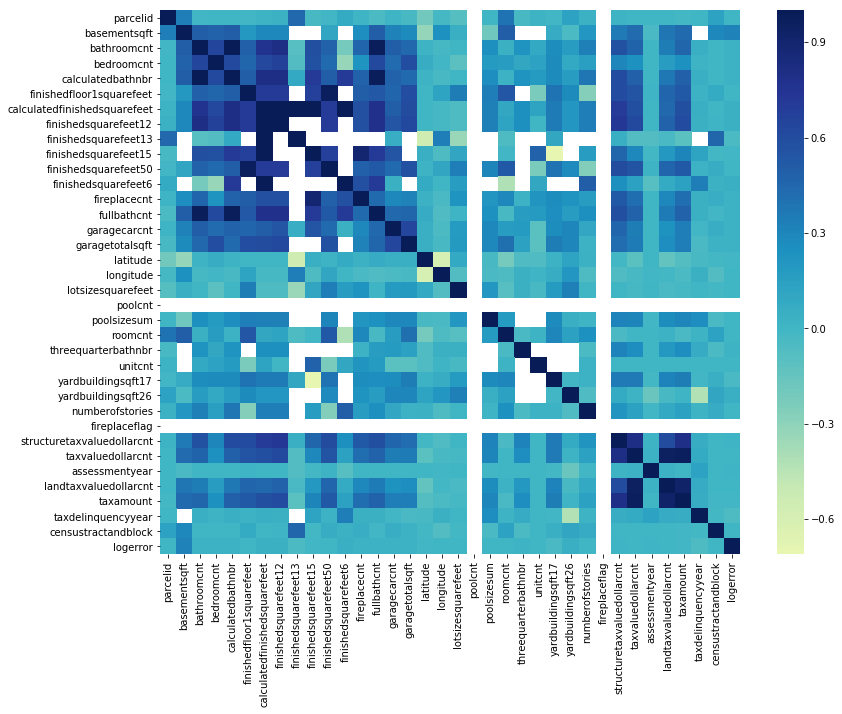

<Figure size 432x288 with 0 Axes>

In [7]:
#Identify numerical columns to produce a heatmap
catcols = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid',
           'decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7',
           'propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock',
           'regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid',
           'typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in combined_df.columns if x not in catcols]

#Lets start by plotting a heatmap to determine if any variables are correlated
plt.figure(figsize = (13,10))
sns.heatmap(data=combined_df[numcols].corr(), center=0,cmap="YlGnBu")
plt.show()
plt.gcf().clear()

We had a few redundant columns, mostly related to squarefeet. So we will drop the finishedsquarefeet columns in favour of calculatedfinishedsquarefeet as they all contain the same information. We will also drop calculatedbathnbr and fullbathcnt since they have the same information as bathroomcnt.

We also have a number of null values representing False, or 'no' values which will be filled in as needed.

In [8]:
dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6',
           'finishedsquarefeet50', 'calculatedbathnbr', 'fullbathcnt']

index = combined_df.hashottuborspa.isnull()
combined_df.loc[index,'hashottuborspa'] = 0

print(combined_df.hashottuborspa.value_counts())
print(combined_df.pooltypeid10.value_counts())

0.0    163984
1.0      3904
Name: hashottuborspa, dtype: int64
1.0    1626
Name: pooltypeid10, dtype: int64


In [9]:
#'pooltypeid10' seems to disagree with hashottuborspa and has fewer values, so we will remove it
dropcols.append('pooltypeid10')

#We will convert null values to 0, where if the count is null, the property has no pools.
index = combined_df.pooltypeid2.isnull()
combined_df.loc[index,'pooltypeid2'] = 0

index = combined_df.pooltypeid7.isnull()
combined_df.loc[index,'pooltypeid7'] = 0

index = combined_df.poolcnt.isnull()
combined_df.loc[index,'poolcnt'] = 0

We have another mismatch where poolsizesum has more missing values than poolcnt. So that means there must be some pools unaccounted for in poolsizesum. We will fill this with the average pool size, and if it doesnt have a pool, we will fill with 0.

There are also mismatches between fireplaceflag and fireplacecnt. We will simply remove fireplaceflag since it is redundant.

We also look at the garage features, where null values indicate no garages, or zeros.

In [10]:
print('pool size discrepancy')
print('poolsizesum null values: ', combined_df.poolsizesum.isnull().sum())
print('poolcnt values: ', combined_df.poolcnt.value_counts())
print('-----')
print('fireplace discrepancy')
print('fireplaceflag null values: ', combined_df.fireplaceflag.isnull().sum())
print('fireplacecnt null values: ', combined_df.fireplacecnt.isnull().sum())

pool size discrepancy
poolsizesum null values:  166050
poolcnt values:  0.0    133813
1.0     34075
Name: poolcnt, dtype: int64
-----
fireplace discrepancy
fireplaceflag null values:  167494
fireplacecnt null values:  149992


In [11]:
avg_poolsize = combined_df.loc[combined_df['poolcnt'] > 0, 'poolsizesum'].median()
combined_df.loc[(combined_df['poolcnt'] > 0) & (combined_df['poolsizesum'].isnull()), 'poolsizesum'] = avg_poolsize
combined_df.loc[(combined_df['poolcnt'] == 0), 'poolsizesum'] = 0

dropcols.append('fireplaceflag')
index = combined_df.fireplacecnt.isnull()
combined_df.loc[index,'fireplacecnt'] = 0

index = combined_df.garagecarcnt.isnull()
combined_df.loc[index,'garagecarcnt'] = 0

index = combined_df.garagetotalsqft.isnull()
combined_df.loc[index,'garagetotalsqft'] = 0

Next we will fill null values with 'good guesses.' This can be used for Airconditioning where we will guess that the missing values are for properties which have AC, this is the already the most common value and the properties are in california, that is a reasonable assumption.

Similarly, we will assume missing values for heating are for central heating since it is also the most common value. Along with threequarterbathnbr with the value 1.

In [12]:
print(combined_df['heatingorsystemtypeid'].value_counts())
print(combined_df['threequarterbathnbr'].value_counts())

2.0     71936
7.0     29626
24.0     1921
6.0      1747
20.0      201
13.0      136
18.0       48
1.0        26
10.0        5
11.0        2
14.0        2
12.0        1
Name: heatingorsystemtypeid, dtype: int64
1.0    21934
2.0      165
3.0       14
7.0        1
4.0        1
Name: threequarterbathnbr, dtype: int64


In [13]:
combined_df['airconditioningtypeid'].value_counts()
index = combined_df.airconditioningtypeid.isnull()
combined_df.loc[index,'airconditioningtypeid'] = 1

index = combined_df.heatingorsystemtypeid.isnull()
combined_df.loc[index,'heatingorsystemtypeid'] = 2

index = combined_df.threequarterbathnbr.isnull()
combined_df.loc[index,'threequarterbathnbr'] = 1

Next we will remove features which contain almost entirely empty values, in this case we will drop any feature with more than 80% empty values.

In [14]:
proportion_missing = (combined_df.isnull().sum()/len(combined_df)).reset_index()
proportion_missing.columns = ['field','proportion']
proportion_missing = proportion_missing.sort_values(by = 'proportion', ascending = False)

bad_cols = proportion_missing[proportion_missing['proportion'] > 0.80].field.tolist()
dropcols = dropcols + bad_cols
combined_df = combined_df.drop(dropcols, axis=1)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167888 entries, 0 to 77612
Data columns (total 40 columns):
parcelid                        167888 non-null int64
airconditioningtypeid           167888 non-null float32
bathroomcnt                     167854 non-null float32
bedroomcnt                      167854 non-null float32
buildingqualitytypeid           107173 non-null float32
calculatedfinishedsquarefeet    166992 non-null float32
fips                            167854 non-null float32
fireplacecnt                    167888 non-null float32
garagecarcnt                    167888 non-null float32
garagetotalsqft                 167888 non-null float32
hashottuborspa                  167888 non-null float32
heatingorsystemtypeid           167888 non-null float32
latitude                        167854 non-null float32
longitude                       167854 non-null float32
lotsizesquarefeet               149446 non-null float32
poolcnt                         167888 non-null floa

Our next major work is to use K-nearest-neighbours to use latitude and longitude to fill in geographical data. I will use the function from https://www.kaggle.com/auroralht/restoring-the-missing-geo-data.

However, there are a very small number of observations which lack lat and long data, so we will need to remove them.

These features are buildingqualitytypeid, propertycountylandusecode, propertyzoningdesc, regionidcity, regionidneighborhood, regionidzip and unitcnt.

In [15]:
def fillna_knn( df, base, target, fraction = 1, threshold = 10 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = 5
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'predicting' )
    Z = clf.predict(df.loc[miss, base])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df' )    
        df.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unpredictable data: ', numunperdicted )
        return enc
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )

def zoningcode_int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

    df[ target ]= enc.fit_transform( df[ target ].values )
    df.loc[ storenull, target ] = np.nan
    return enc

In [16]:
combined_df = combined_df.dropna(subset=['latitude', 'longitude'])
#combined_df.info()

In [17]:
fillna_knn(df = combined_df, 
                  base = [ 'latitude', 'longitude' ] , 
                  target = 'buildingqualitytypeid', fraction = 0.15)

zoningcode_int(df = combined_df, target = 'propertycountylandusecode' )

fillna_knn(df = combined_df, base = [ 'latitude', 'longitude' ],
                  target = 'propertycountylandusecode')#, fraction = 0.15 )

zoningcode_int(df = combined_df, target = 'propertyzoningdesc')

fillna_knn(df = combined_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertyzoningdesc')#, fraction = 0.15 )


fillna_knn(df = combined_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity')#, fraction = 0.15 )

fillna_knn(df = combined_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidneighborhood')#, fraction = 0.15 )

fillna_knn(df = combined_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip')#, fraction = 0.15 )

fillna_knn(df = combined_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'unitcnt')#, fraction = 0.15 )

#fillna_knn( df = combined_df,
                  #base = [ 'latitude', 'longitude' ] ,
                  #target = 'yearbuilt')#, fraction = 0.15 )

fillna_knn( df = combined_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'lotsizesquarefeet', fraction = 0.5 )

fitting
the shape of active features:  (12,)
predicting
writing result to df
num of unpredictable data:  427.0
fitting
the shape of active features:  (90,)
predicting
writing result to df
num of unpredictable data:  0.0
fitting
the shape of active features:  (2346,)
predicting
writing result to df
num of unpredictable data:  0.0
fitting
the shape of active features:  (178,)
predicting
writing result to df
num of unpredictable data:  2.0
fitting
the shape of active features:  (505,)
predicting
writing result to df
num of unpredictable data:  326.0
fitting
the shape of active features:  (390,)
predicting
writing result to df
num of unpredictable data:  0.0
fitting
the shape of active features:  (13,)
predicting
writing result to df
num of unpredictable data:  4991.0
fitting
the shape of active features:  (19424,)
predicting
writing result to df
num of unpredictable data:  0.0


OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [18]:
print(combined_df.isnull().sum())

parcelid                             0
airconditioningtypeid                0
bathroomcnt                          0
bedroomcnt                           0
buildingqualitytypeid                0
calculatedfinishedsquarefeet       862
fips                                 0
fireplacecnt                         0
garagecarcnt                         0
garagetotalsqft                      0
hashottuborspa                       0
heatingorsystemtypeid                0
latitude                             0
longitude                            0
lotsizesquarefeet                    0
poolcnt                              0
poolsizesum                          0
pooltypeid2                          0
pooltypeid7                          0
propertycountylandusecode            0
propertylandusetypeid                0
propertyzoningdesc                   0
rawcensustractandblock               0
regionidcity                         0
regionidcounty                       0
regionidneighborhood     

We will use a similar approach to filling in tax ammounts. First we will try to fill the two values for taxvaluedollarcnt with those from taxamount.

In [19]:
combined_df[combined_df.taxvaluedollarcnt.isnull()]['taxamount']

22541     51.400002
51862    388.179993
Name: taxamount, dtype: float32

In [20]:
combined_df.loc[combined_df.taxvaluedollarcnt.isnull(),
                'taxvaluedollarcnt'] = combined_df.loc[combined_df.taxvaluedollarcnt.isnull(),'taxamount']
combined_df.loc[combined_df.landtaxvaluedollarcnt.isnull(),
             'landtaxvaluedollarcnt'] = combined_df.loc[combined_df.landtaxvaluedollarcnt.isnull(),'taxamount']

In [21]:
def fillna_knn_reg( df, base, target, n_neighbors = 5 ):
    cols = base + [target]
    X_train = df[cols]
    scaler = StandardScaler(with_mean=True, with_std=True).fit(X_train[base].values.reshape(-1, 1))
    rescaledX = scaler.transform(X_train[base].values.reshape(-1, 1))

    X_train = rescaledX[df[target].notnull()]
    Y_train = df.loc[df[target].notnull(),target].values.reshape(-1, 1)

    knn = KNeighborsRegressor(n_neighbors, n_jobs = -1)    
    knn.fit(X_train, Y_train)
    X_test = rescaledX[df[target].isnull()]
    pred = knn.predict(X_test)
    df.loc[combined_df[target].isnull(),target] = pred
    return

fillna_knn_reg(df = combined_df, base = ['taxvaluedollarcnt'], target = 'structuretaxvaluedollarcnt')

fillna_knn_reg(df = combined_df, base = ['taxvaluedollarcnt'], target = 'taxamount')
print(combined_df.isnull().sum())

parcelid                             0
airconditioningtypeid                0
bathroomcnt                          0
bedroomcnt                           0
buildingqualitytypeid                0
calculatedfinishedsquarefeet       862
fips                                 0
fireplacecnt                         0
garagecarcnt                         0
garagetotalsqft                      0
hashottuborspa                       0
heatingorsystemtypeid                0
latitude                             0
longitude                            0
lotsizesquarefeet                    0
poolcnt                              0
poolsizesum                          0
pooltypeid2                          0
pooltypeid7                          0
propertycountylandusecode            0
propertylandusetypeid                0
propertyzoningdesc                   0
rawcensustractandblock               0
regionidcity                         0
regionidcounty                       0
regionidneighborhood     

## Feature Creation
****

Now we will do some simple feature creation. Starting with space of the property.

In [22]:
#proportion of living area
combined_df['LivingAreaProp'] = combined_df['calculatedfinishedsquarefeet']/combined_df['lotsizesquarefeet']

# We will reduce the number of propertylandusetypeid
combined_df['PropUseType'] = combined_df.propertylandusetypeid.replace({31 : 1, 46 : 2, 47 : 1, 
                                                                 246 : 1, 247 : 1, 248 : 1, 
                                                                 260 : 3, 261 : 3, 262 : 3, 
                                                                 263 : 3, 264 : 3, 265 : 3, 
                                                                 266 : 3, 267 : 3, 268 : 3, 
                                                                 269 : 4, 270 : 3, 271 : 3, 
                                                                 273 : 3, 274 : 2, 275 : 3, 
                                                                 276 : 3, 279 : 3, 290 : 4, 
                                                                 291 : 4 })

#Average structuretaxvaluedollarcnt by city
group = combined_df.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
combined_df['tax_avg'] = combined_df['regionidcity'].map(group)

#Deviation away from average
combined_df['tax_deviation'] = abs((combined_df['structuretaxvaluedollarcnt'] - 
                                    combined_df['tax_avg']))/combined_df['tax_avg']

combined_df.head()

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,...,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,LivingAreaProp,PropUseType,tax_avg,tax_deviation
0,17073783,1.0,2.5,3.0,9.0,1264.0,6111.0,0.0,2.0,0.0,...,2015.0,76724.0,2015.060059,6.111002e+13,0.0953,2016-01-27,0.728530,3.0,158582.578125,0.274277
1,17088994,1.0,1.0,2.0,9.0,777.0,6111.0,0.0,1.0,0.0,...,2015.0,95870.0,2581.300049,6.111002e+13,0.0198,2016-03-30,inf,3.0,158582.578125,0.093160
2,17100444,1.0,2.0,3.0,9.0,1101.0,6111.0,0.0,2.0,441.0,...,2015.0,14234.0,591.640015,6.111001e+13,0.0060,2016-05-27,0.167605,3.0,130160.945312,0.741712
3,17102429,1.0,1.5,2.0,9.0,1554.0,6111.0,1.0,2.0,460.0,...,2015.0,17305.0,682.780029,6.111001e+13,-0.0566,2016-06-07,0.210000,3.0,130160.945312,0.649595
4,17109604,1.0,2.5,4.0,9.0,2415.0,6111.0,1.0,2.0,665.0,...,2015.0,277000.0,5886.919922,6.111002e+13,0.0573,2016-08-08,0.381758,3.0,158582.578125,0.746724


In [23]:
combined_df['transactiondate'] = pd.to_datetime(combined_df['transactiondate'], 
                                                 format = '%Y-%m-%d', errors = 'coerce')
combined_df = combined_df.drop(['numberofstories'], axis=1)#possibly do something better with these.
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167854 entries, 0 to 77578
Data columns (total 43 columns):
parcelid                        167854 non-null int64
airconditioningtypeid           167854 non-null float32
bathroomcnt                     167854 non-null float32
bedroomcnt                      167854 non-null float32
buildingqualitytypeid           167854 non-null float32
calculatedfinishedsquarefeet    166992 non-null float32
fips                            167854 non-null float32
fireplacecnt                    167854 non-null float32
garagecarcnt                    167854 non-null float32
garagetotalsqft                 167854 non-null float32
hashottuborspa                  167854 non-null float32
heatingorsystemtypeid           167854 non-null float32
latitude                        167854 non-null float32
longitude                       167854 non-null float32
lotsizesquarefeet               167854 non-null float32
poolcnt                         167854 non-null floa

In [24]:
combined_df.to_csv('cleaned_1.csv')